In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


Importing the dataset

In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [00:17<00:00, 215MB/s]
100% 1.76G/1.76G [00:17<00:00, 105MB/s]


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall()
    print('The dataset has been extracted.')


The dataset has been extracted.


In [ ]:
path = '/content/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_scc', 'lung_n', 'lung_aca']

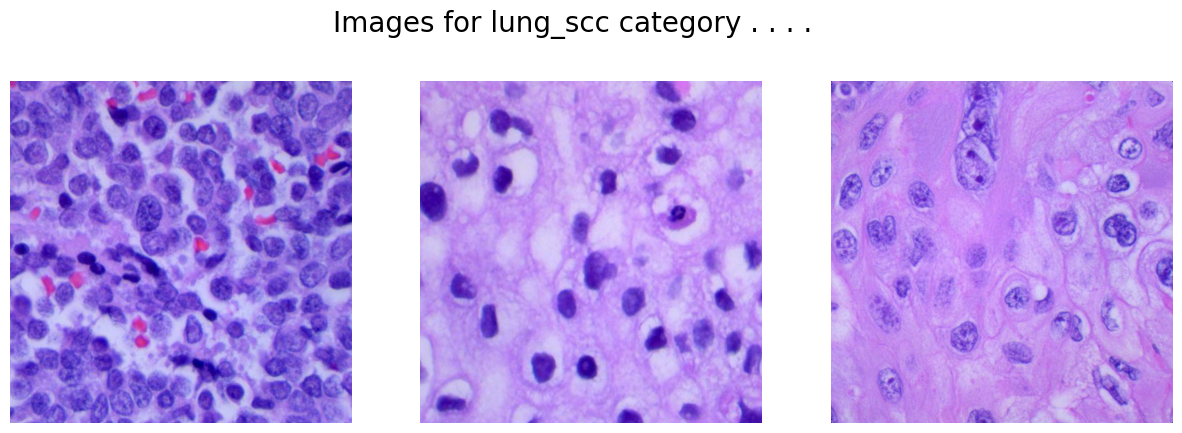

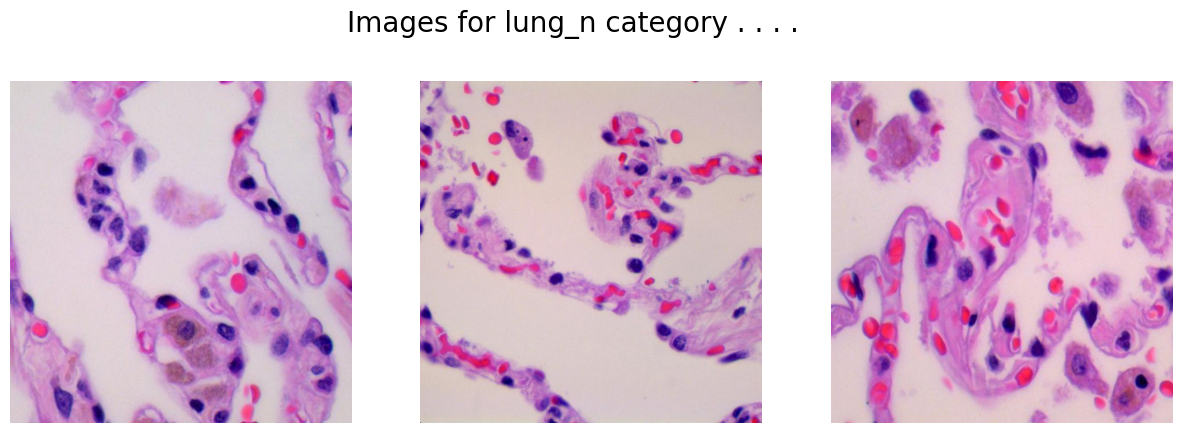

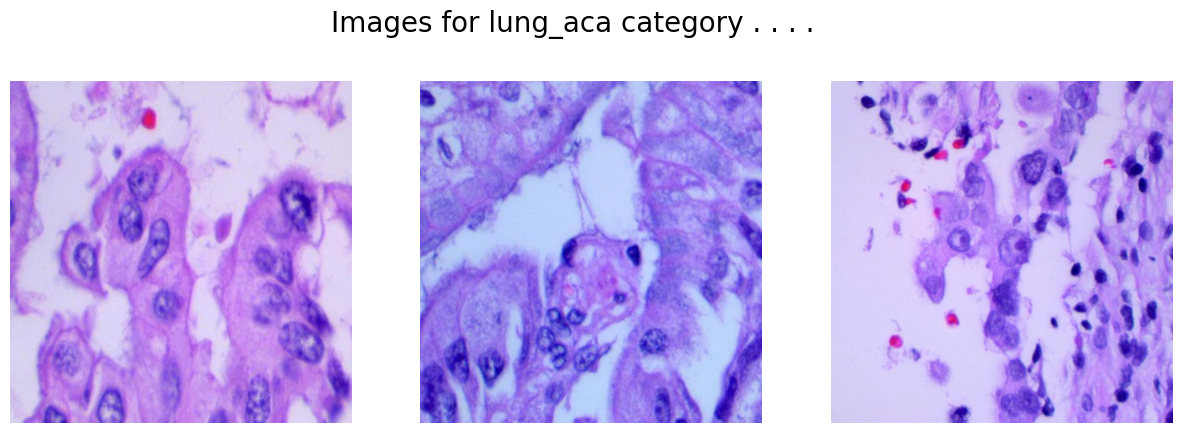

In [ ]:
path = '/content/lung_colon_image_set/lung_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


In [ ]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [ ]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
												test_size = SPLIT,
												random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


In [ ]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

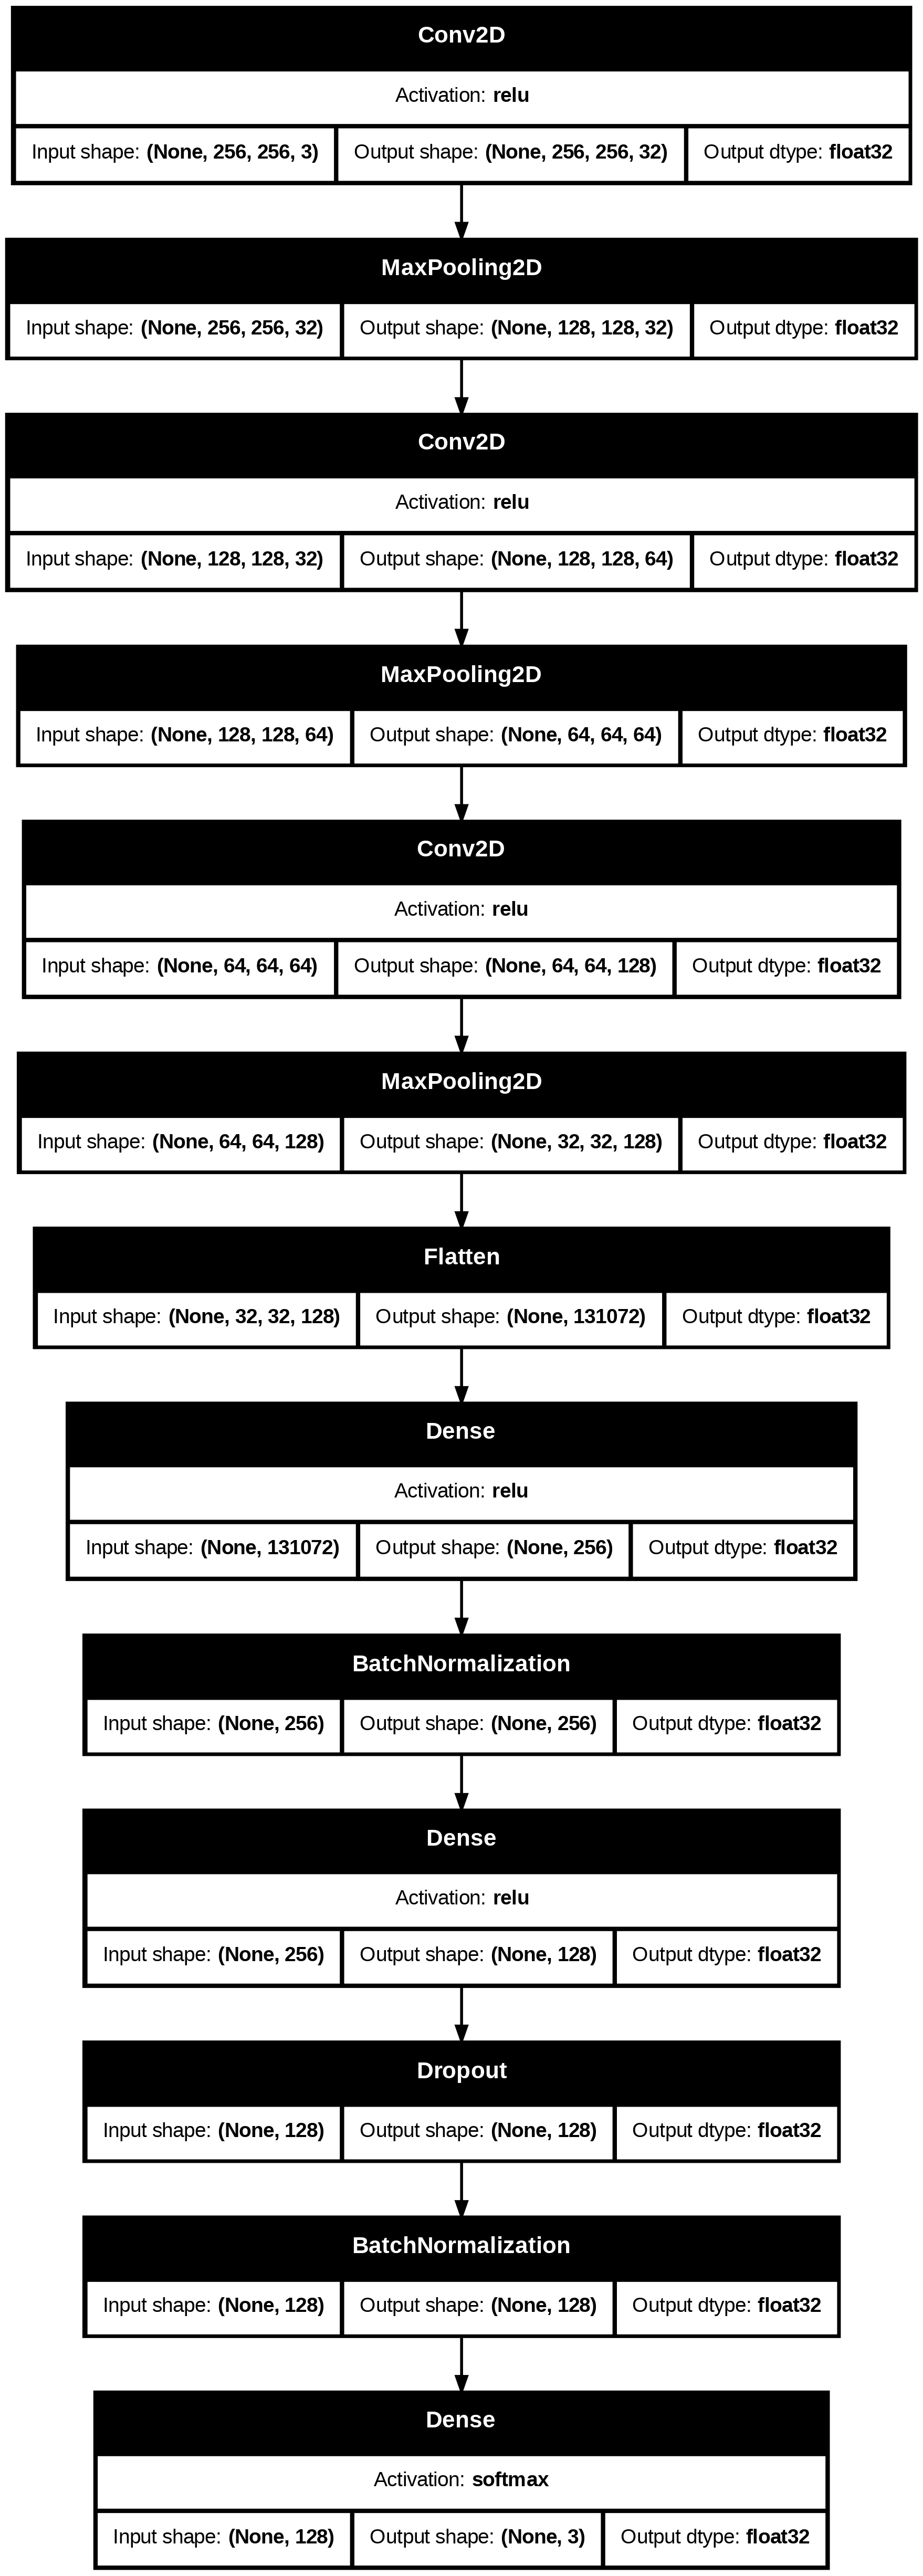

In [ ]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


In [ ]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [ ]:
history = model.fit(X_train, Y_train,validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.7871 - loss: 0.4959 - val_accuracy: 0.3453 - val_loss: 12.1656 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - accuracy: 0.8976 - loss: 0.2562 - val_accuracy: 0.8653 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.9278 - loss: 0.1787 - val_accuracy: 0.4640 - val_loss: 2.5126 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9446 - loss: 0.1392
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - accuracy: 0.9446 - loss: 0.1392 - val_accuracy: 0.4640 - val_loss: 3.5100 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.9630 - loss: 0.0995 - val_accuracy: 0.6820 - val_loss: 2.3477 - learning_rate: 5.0000e-04


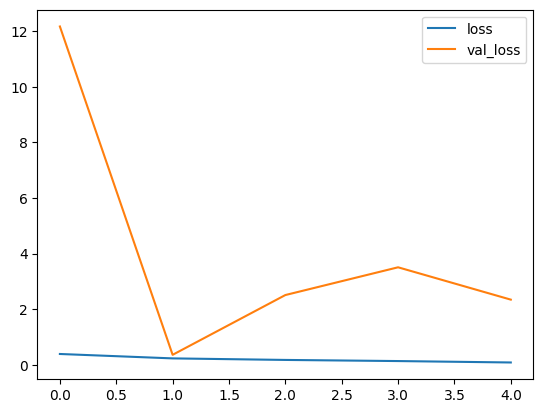

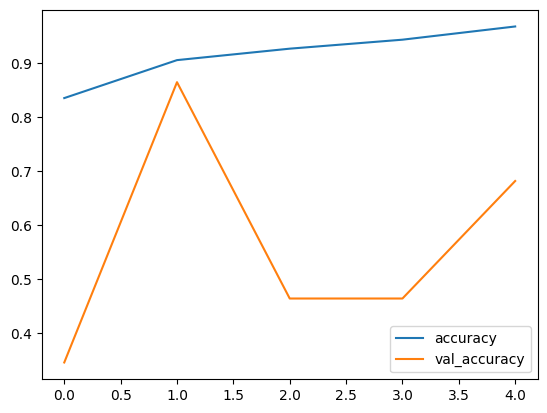

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [ ]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step


In [ ]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[809,   0, 178],
       [  1, 964,  12],
       [165,  48, 823]])

In [ ]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

    lung_scc       0.83      0.82      0.82       987
      lung_n       0.95      0.99      0.97       977
    lung_aca       0.81      0.79      0.80      1036

    accuracy                           0.87      3000
   macro avg       0.86      0.87      0.87      3000
weighted avg       0.86      0.87      0.86      3000

